# 3. Similitud entre productos

In [1]:
import re, nltk, bs4
import pandas as pd
import numpy as np
from numpy.linalg import norm
import scipy as sp
from scipy.sparse import csr_matrix as csr
import random
from string import punctuation
from nltk.corpus import stopwords
from collections import defaultdict
import string


In [2]:
df_titles = pd.read_csv('items_titles.csv', encoding='utf-8-sig')

In [3]:
df_titles.head()

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...


# LIMPIEZA DE TEXTOS

In [4]:
# Define número de palabras relevantes
stop_words = set(stopwords.words('portuguese'))

In [5]:
# Elimina las palabras que no son importantes (stopwords)
def remove_stopwords_br(sentence):
    sentence = [token.lower() for token in nltk.word_tokenize(sentence) if (token.lower() not in stop_words)]
    return " ".join(sentence)

In [6]:
def remove_shortwords(sentence):
    sentence = [token for token in nltk.word_tokenize(sentence) if len(token)>2]
    return " ".join(sentence)

In [7]:
df_titles['ITE_ITEM_TITLE'] = df_titles['ITE_ITEM_TITLE'].apply(remove_stopwords_br)
df_titles

,ITE_ITEM_TITLE
0,tênis ascension posh masculino - preto vermelho
1,tenis caminhada super levinho spider corrida
2,tênis feminino le parc hocks black/ice origina...
3,tênis olympikus esportivo academia nova tendên...
4,inteligente led bicicleta tauda luz usb bicicl...
...,...
29995,tênis vans old skool i love my vans - usado - ...
29996,tênis feminino preto moleca 5296155
29997,tenis botinha via marte original lançamento
29998,tênis slip on feminino masculino original sapa...


In [8]:
def remove_accents(sent):
    trans = str.maketrans( 'àáâãäåèéêëìíîïòóôõöùúûü','aaaaaaeeeeiiiiooooouuuu')
    sent = sent.translate(trans)
    return sent

In [9]:
def clean(sentence):
    sentence = re.sub(r'[0-9]', ' ', sentence)
    sentence = sentence.replace('tv','televisao')
    sentence = sentence.replace('ñ','n')
    sentence = sentence.replace('\x81','')
    sentence = sentence.replace('ç','c')
    #sentence = sentence.translate(str.maketrans(' ', ' ', string.punctuation)) 
    sentence = re.sub(r"[!\"'#$%&()*+,-\.\/:;<=>?@[\\\]^_`{|}~]", ' ',sentence)
    sentence = re.sub(r'\s{2,}', ' ', sentence)
    sentence = remove_accents(sentence)
    sentence = remove_shortwords(sentence)
    sentence = sentence.strip()
    return sentence
    

In [10]:
df_titles['ITE_ITEM_TITLE'] = df_titles['ITE_ITEM_TITLE'].apply(clean)
df_titles

,ITE_ITEM_TITLE
0,tenis ascension posh masculino preto vermelho
1,tenis caminhada super levinho spider corrida
2,tenis feminino parc hocks black ice original e...
3,tenis olympikus esportivo academia nova tenden...
4,inteligente led bicicleta tauda luz usb bicicl...
...,...
29995,tenis vans old skool love vans usado feminino
29996,tenis feminino preto moleca
29997,tenis botinha via marte original lancamento
29998,tenis slip feminino masculino original sapato ...


In [11]:
df_titles.to_csv('limpio_titulos.csv')

In [12]:
def createVocab( docList):
    vocab = {}
    for doc in docList:
        doc= doc.translate(str.maketrans('', '', string.punctuation))
        
        words= nltk.word_tokenize(doc.lower())
        for word in words:
            if(word in vocab.keys()):
                vocab[word] = vocab[word] +1
            else:
                vocab[word] =1 
    return vocab

vocab = createVocab(df_titles['ITE_ITEM_TITLE'])

In [13]:
 dict(sorted(vocab.items(), key=lambda item: item[1],reverse=True))

{'tenis': 22601,
 'feminino': 7931,
 'masculino': 5350,
 'casual': 3757,
 'preto': 3669,
 'infantil': 3497,
 'original': 2768,
 'sapatenis': 2630,
 'bicicleta': 2248,
 'branco': 1722,
 'aro': 1678,
 'couro': 1496,
 'olympikus': 1491,
 'slip': 1430,
 'promocao': 1267,
 'confortavel': 1214,
 'academia': 1098,
 'kit': 1014,
 'caminhada': 961,
 'sapatilha': 951,
 'azul': 942,
 'rosa': 916,
 'leve': 898,
 'esportivo': 844,
 'usthemp': 827,
 'corrida': 794,
 'cano': 747,
 'conforto': 704,
 'lancamento': 704,
 'televisao': 684,
 'bike': 669,
 'led': 652,
 'plataforma': 652,
 'menina': 632,
 'cadarco': 574,
 'menino': 561,
 'pares': 555,
 'cinza': 555,
 'marinho': 554,
 'star': 538,
 'alto': 521,
 'nike': 516,
 'mtb': 511,
 'barato': 501,
 'via': 490,
 'fila': 485,
 'chunky': 482,
 'mizuno': 482,
 'sapato': 481,
 'adidas': 477,
 'facil': 463,
 'sneaker': 458,
 'unissex': 453,
 'envio': 449,
 'meia': 447,
 'vermelho': 445,
 'black': 439,
 'calce': 438,
 'shimano': 433,
 'moleca': 429,
 'tematic

# TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
select_list= df_titles['ITE_ITEM_TITLE'].tolist()

In [16]:
select_list = select_list[0:5]

In [17]:
select_list

['tenis ascension posh masculino preto vermelho',
 'tenis caminhada super levinho spider corrida',
 'tenis feminino parc hocks black ice original envio',
 'tenis olympikus esportivo academia nova tendencia triunfo',
 'inteligente led bicicleta tauda luz usb bicicleta carregave']

In [18]:
import spacy
nlp = spacy.load("pt_core_news_sm")
def tokenize_phrase(phrase):
    parsed_phrase = nlp(phrase)
    for token in parsed_phrase:
        if token.is_punct or token.is_stop or token.text.lower() in stop_words:
            continue
        yield token.lemma_.lower()

In [19]:
vectorizer = TfidfVectorizer(analyzer=tokenize_phrase, use_idf=True,smooth_idf=True)
tf_idf = vectorizer.fit_transform(select_list)

In [20]:
feature_names = sorted(vectorizer.get_feature_names_out())


In [21]:
docList = list(range(5))

In [22]:
skDocsTfIdfdf = pd.DataFrame(tf_idf.todense(), index=sorted(docList), columns=feature_names)
print(skDocsTfIdfdf)

   academiar  ascension  bicicleta     black  caminhar  carregave   corrido  \
0   0.000000   0.433661   0.000000  0.000000  0.000000   0.000000  0.000000   
1   0.000000   0.000000   0.000000  0.000000  0.433661   0.000000  0.433661   
2   0.000000   0.000000   0.000000  0.369676  0.000000   0.000000  0.000000   
3   0.433661   0.000000   0.000000  0.000000  0.000000   0.000000  0.000000   
4   0.000000   0.000000   0.632456  0.000000  0.000000   0.316228  0.000000   

     enviar  esportivo  feminino  ...      posh     preto    spider     super  \
0  0.000000   0.000000  0.000000  ...  0.433661  0.433661  0.000000  0.000000   
1  0.000000   0.000000  0.000000  ...  0.000000  0.000000  0.433661  0.433661   
2  0.369676   0.000000  0.369676  ...  0.000000  0.000000  0.000000  0.000000   
3  0.000000   0.433661  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
4  0.000000   0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

      tauda  tendencia     tenis  triu

In [23]:
#compute cosine similarity
csim = cosine_similarity(tf_idf,tf_idf)

csim_df = pd.DataFrame(csim,index=sorted(docList),columns=sorted(docList))

In [24]:
csim_df

,0,1,2,3,4
0,1.000000,0.059691,0.050884,0.059691,0.0
1,0.059691,1.000000,0.050884,0.059691,0.0
2,0.050884,0.050884,1.000000,0.050884,0.0
3,0.059691,0.059691,0.050884,1.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,1.0


In [25]:
def get_resul_df(csimdf):
    resul_df = pd.DataFrame()
    item1_list = []
    item2_list = []
    score = []
    for i,j in csimdf.iterrows():
        for item1 in range(len(select_list)):
            for item2 in  range(len(select_list)):
                item1_list.append(select_list[item1])
                item2_list.append(select_list[item2])
                score.append(csimdf[item1][item2])
    resul_df['ITE_ITEM_TITLE1'] = item1_list
    resul_df['ITE_ITEM_TITLE2'] = item2_list
    resul_df['Score Similitud (0,1)'] = score
    return resul_df

In [26]:
resul_df = get_resul_df(csim_df)
resul_df

,ITE_ITEM_TITLE1,ITE_ITEM_TITLE2,"Score Similitud (0,1)"
0,tenis ascension posh masculino preto vermelho,tenis ascension posh masculino preto vermelho,1.000000
1,tenis ascension posh masculino preto vermelho,tenis caminhada super levinho spider corrida,0.059691
2,tenis ascension posh masculino preto vermelho,tenis feminino parc hocks black ice original e...,0.050884
3,tenis ascension posh masculino preto vermelho,tenis olympikus esportivo academia nova tenden...,0.059691
4,tenis ascension posh masculino preto vermelho,inteligente led bicicleta tauda luz usb bicicl...,0.000000
...,...,...,...
120,inteligente led bicicleta tauda luz usb bicicl...,tenis ascension posh masculino preto vermelho,0.000000
121,inteligente led bicicleta tauda luz usb bicicl...,tenis caminhada super levinho spider corrida,0.000000
122,inteligente led bicicleta tauda luz usb bicicl...,tenis feminino parc hocks black ice original e...,0.000000
123,inteligente led bicicleta tauda luz usb bicicl...,tenis olympikus esportivo academia nova tenden...,0.000000


# SBERT

In [27]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at C:\Users\Administrador/.cache\torch\sentence_transformers\neuralmind_bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
sentence_embeddings = model.encode(select_list)

In [29]:
select_list

['tenis ascension posh masculino preto vermelho',
 'tenis caminhada super levinho spider corrida',
 'tenis feminino parc hocks black ice original envio',
 'tenis olympikus esportivo academia nova tendencia triunfo',
 'inteligente led bicicleta tauda luz usb bicicleta carregave']

In [30]:
# calculate similarities (will store in array)
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
for i in range(sentence_embeddings.shape[0]):
    scores[i, :] = cosine_similarity(
        [sentence_embeddings[i]],
        sentence_embeddings
    )[0]

In [31]:
scores

array([[0.9999997 , 0.72409046, 0.81607878, 0.7272312 , 0.56941128],
       [0.72409046, 0.99999982, 0.77430558, 0.7006346 , 0.58365023],
       [0.81607878, 0.77430558, 1.00000012, 0.76106489, 0.55265981],
       [0.7272312 , 0.7006346 , 0.76106489, 0.99999994, 0.58782005],
       [0.5694114 , 0.58365035, 0.55265999, 0.58782011, 1.00000012]])

In [32]:
csim_df = pd.DataFrame(scores,index=sorted(docList),columns=sorted(docList))

In [33]:
csim_df
resul_df=get_resul_df(csim_df)
resul_df

,ITE_ITEM_TITLE1,ITE_ITEM_TITLE2,"Score Similitud (0,1)"
0,tenis ascension posh masculino preto vermelho,tenis ascension posh masculino preto vermelho,1.000000
1,tenis ascension posh masculino preto vermelho,tenis caminhada super levinho spider corrida,0.724090
2,tenis ascension posh masculino preto vermelho,tenis feminino parc hocks black ice original e...,0.816079
3,tenis ascension posh masculino preto vermelho,tenis olympikus esportivo academia nova tenden...,0.727231
4,tenis ascension posh masculino preto vermelho,inteligente led bicicleta tauda luz usb bicicl...,0.569411
...,...,...,...
120,inteligente led bicicleta tauda luz usb bicicl...,tenis ascension posh masculino preto vermelho,0.569411
121,inteligente led bicicleta tauda luz usb bicicl...,tenis caminhada super levinho spider corrida,0.583650
122,inteligente led bicicleta tauda luz usb bicicl...,tenis feminino parc hocks black ice original e...,0.552660
123,inteligente led bicicleta tauda luz usb bicicl...,tenis olympikus esportivo academia nova tenden...,0.587820


<AxesSubplot:>

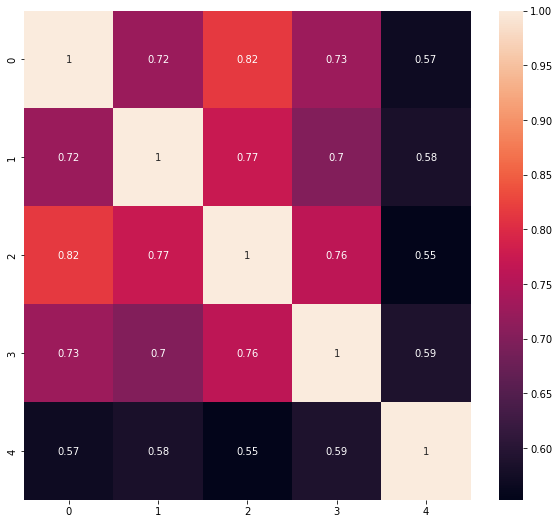

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,9))
sns.heatmap(scores,xticklabels=docList,yticklabels=docList,annot=True)